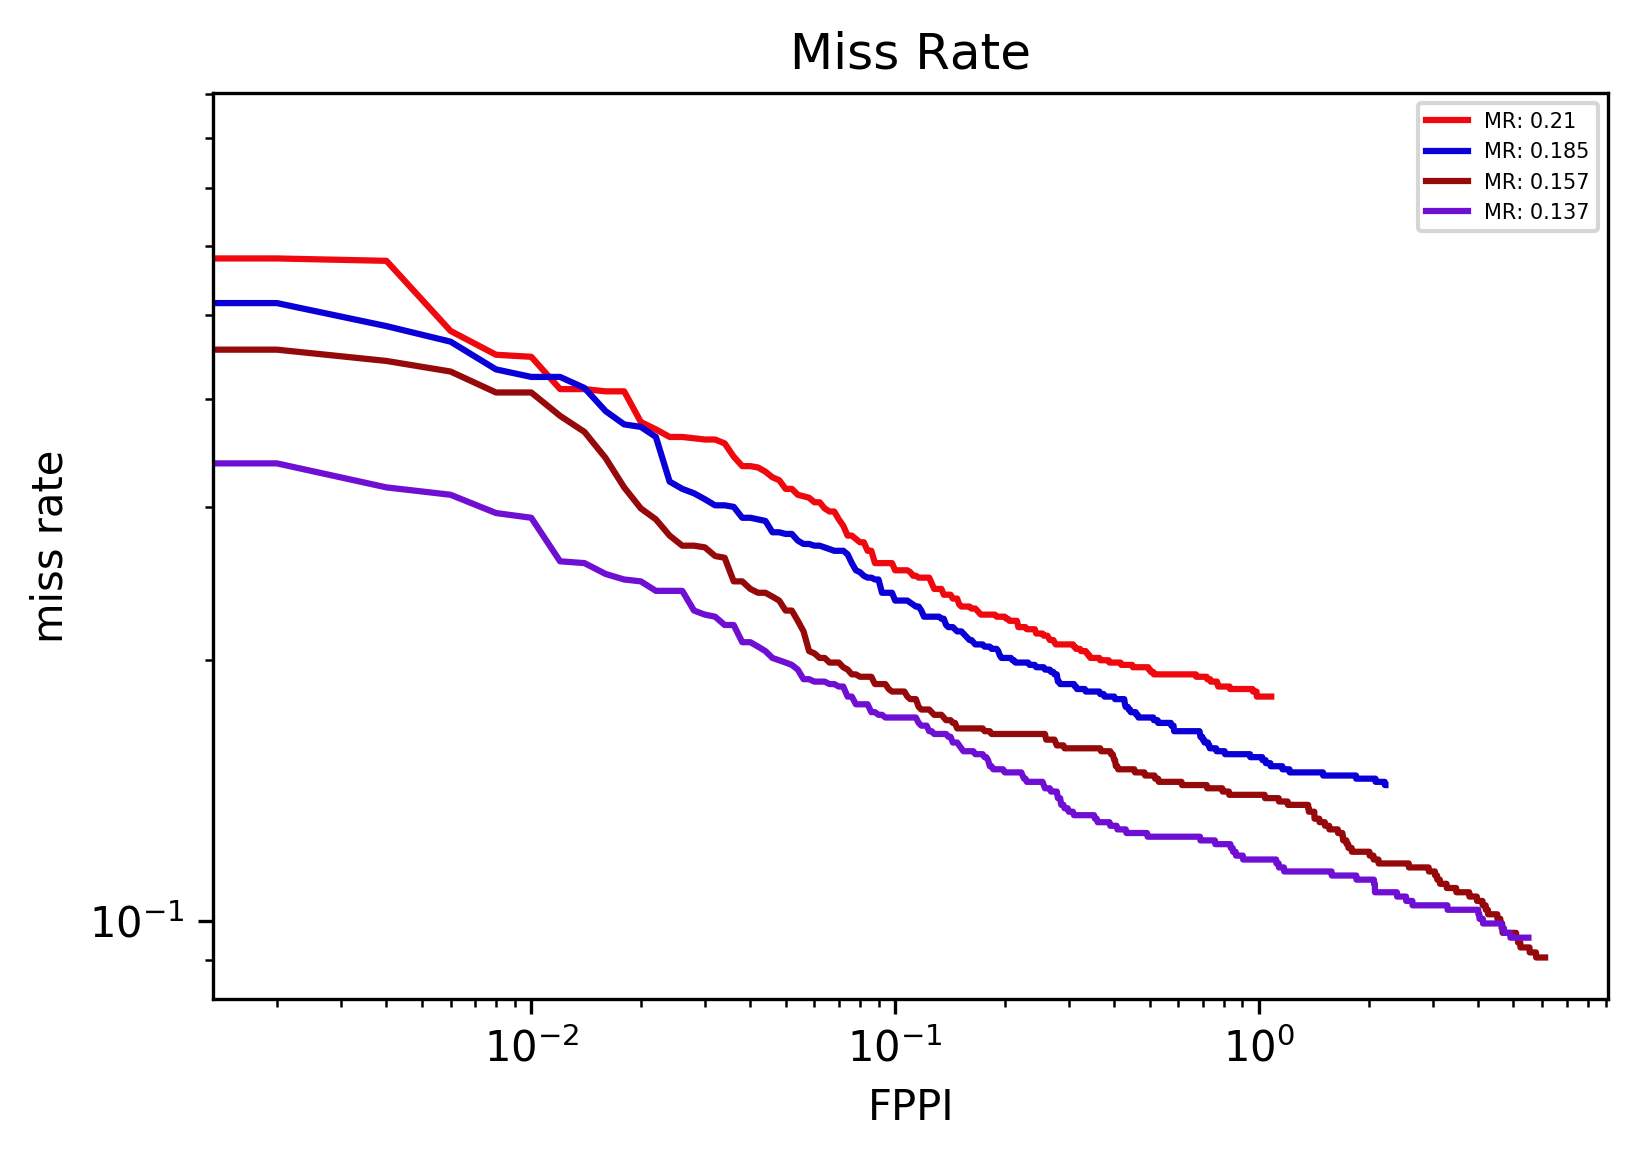

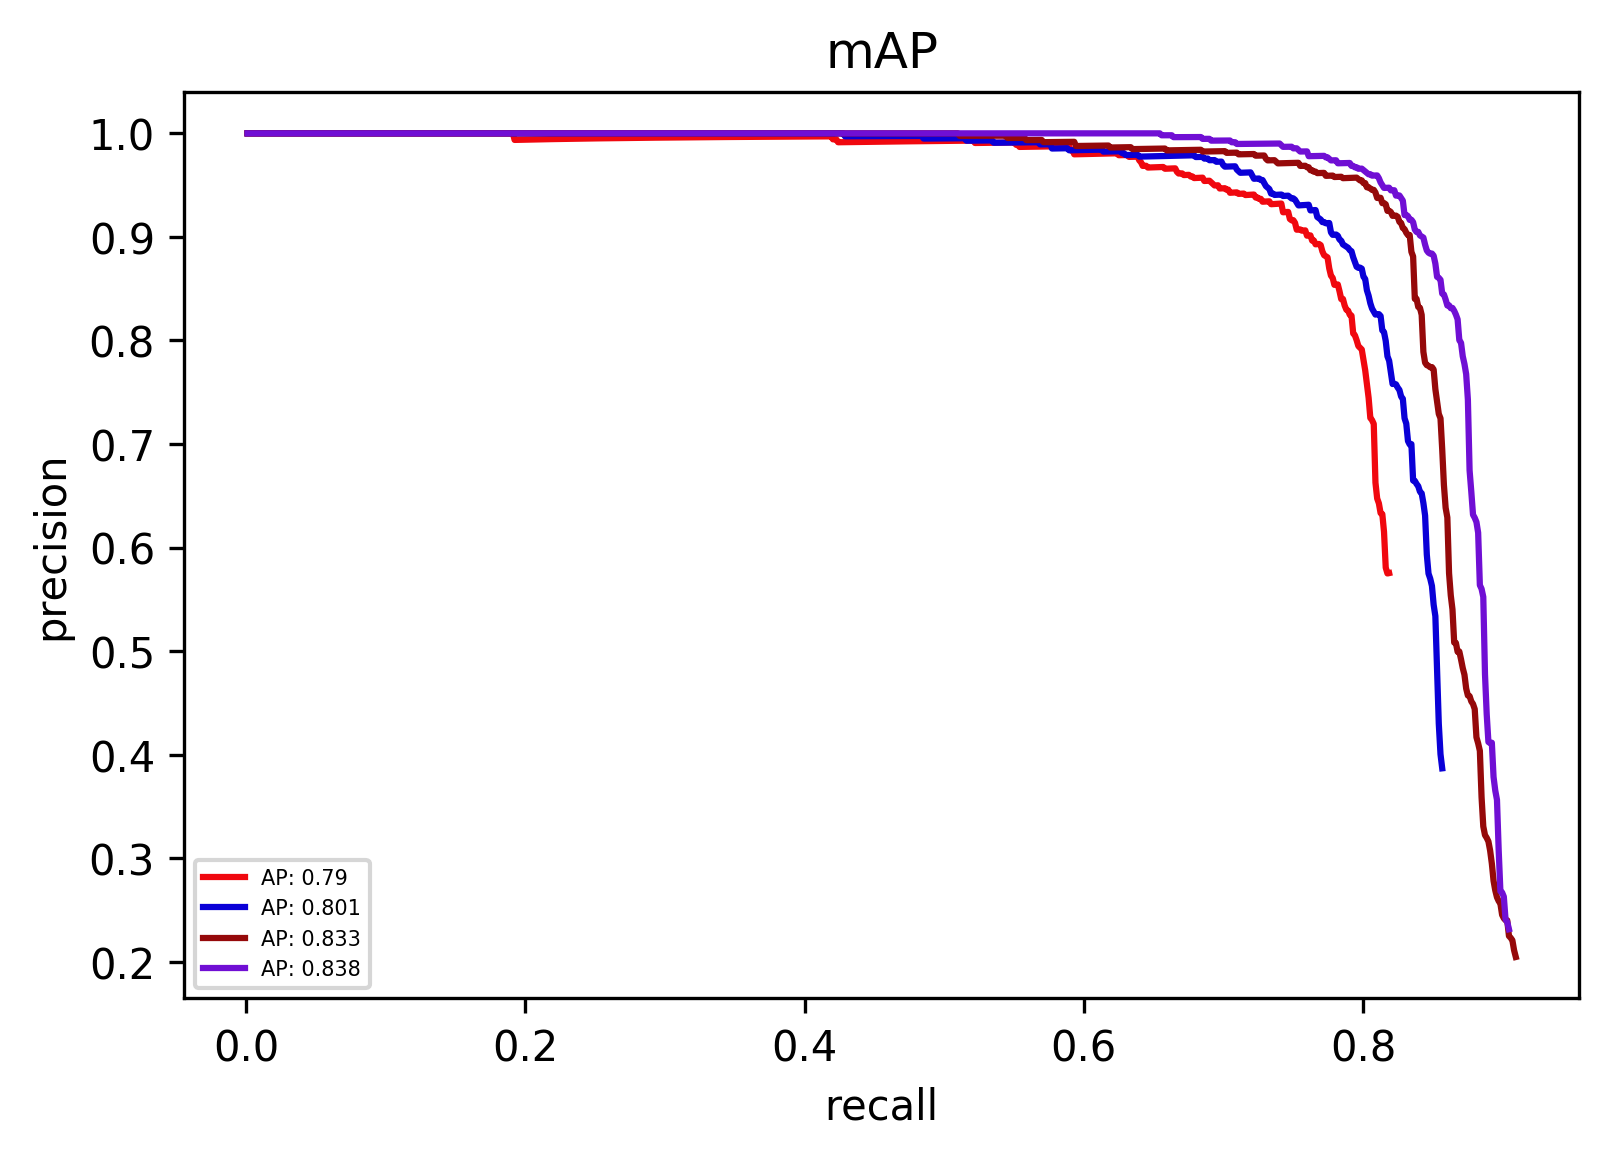

In [11]:
%matplotlib inline
import pdb
import os
import json
import numpy as np
import matplotlib.pyplot as plt

colors = ['#F0080F','#0A00D7','#95090A','#700FD4','#00a0F0','#00050C', '#30b404','#F00F00','#008377','#E0203B', \
          '#F00500','#008000','#0000FF','#F0F0F0','#7C0C00','#E0F00F','#00B000','#000FF0','#ADD806', '#320032', \
         '#48000C', '#C00085','#F5000A', '#00E4B5','#0000E6','#0070D6','#D00003','#DD0000','#FF0000','#2E0057',]

IOU_THRESHOLD=0.5

path_dt='saved_model/validation_results/cross_validation/'

path_gt = 'saved_model/val_gt.json'

test_dir=os.listdir(path_dt)

plt.rcParams['savefig.dpi'] = 250
plt.rcParams['figure.dpi'] = 300
plt.figure(1)
plt.title('Miss Rate')
plt.xlabel('FPPI')
plt.ylabel('miss rate')

list_epoch=list()
list_mr=list()

total_fppi_list=list()
total_miss_list=list()
total_p_list=list()
total_r_list=list()
ap=list()

test_dir=sorted(test_dir)

for test_json in test_dir:
    
    with open(path_gt, 'r') as g:
        gt_all=json.load(g)
    test_json_dir=path_json+test_json
    with open(test_json_dir, 'r') as d:
        dt=json.load(d)
                
    total_fg = 0
    gt_dict={}
    for i in range(len(gt_all['annotations'])):

        if gt_all['annotations'][i]['vis_ratio']>0.85 and gt_all['annotations'][i]['ignore']==0 and gt_all['annotations'][i]['height']>70:
            total_fg+=1 

        if gt_all['annotations'][i]['iscrowd']==1 and gt_all['annotations'][i]['ignore']==0:
            pdb.set_trace()

        if int(gt_all['annotations'][i]['image_id']) in gt_dict:
            gt_dict[int(gt_all['annotations'][i]['image_id'])].append(gt_all['annotations'][i])
        else:
            gt_dict[int(gt_all['annotations'][i]['image_id'])]=[]
            gt_dict[int(gt_all['annotations'][i]['image_id'])].append(gt_all['annotations'][i])


    dt_sorted = sorted(dt, key=lambda k: k['score'], reverse=True)

    false_num=0
    miss_num=total_fg
    true_num=0
    total_fppi=[]
    total_miss=[]
    p=[]
    r=[]

    def IOU(dt):

        if int(dt['image_id']) not in gt_dict:
            return 'fp'

        gt = gt_dict[dt['image_id']]

        iou=list()
        for i in range(len(gt)):
    
            inter_xmin = max(dt['bbox'][0], gt[i]['bbox'][0])
            inter_ymin = max(dt['bbox'][1], gt[i]['bbox'][1])
            inter_xmax = min(dt['bbox'][0]+dt['bbox'][2], gt[i]['bbox'][0]+gt[i]['bbox'][2])
            inter_ymax = min(dt['bbox'][1]+dt['bbox'][3], gt[i]['bbox'][1]+gt[i]['bbox'][3])
            Iw = max(inter_xmax - inter_xmin, 0)
            Ih = max(inter_ymax - inter_ymin, 0)
            I = Iw * Ih
            U = dt['bbox'][2]*dt['bbox'][3] + gt[i]['bbox'][2]*gt[i]['bbox'][3] - I
            iou.append(float(I)/float(U))

        return iou

    def match(dt_sorted):
 
        global gt_dict
        iou = IOU(dt_sorted)
        if iou == 'fp':
            return 'fp'

        iou_index = np.argsort(-np.array(iou))
        iou_sorted = sorted(iou, reverse=True)

        iou_fg=list()
        for i in range(len(iou_sorted)):
            if iou_sorted[i]>IOU_THRESHOLD:
                iou_fg.append(iou_sorted[i])
            else:
                break

        if len(iou_fg)<1:
            return 'fp'

        if len(iou_fg)==1:
            if (gt_dict[dt_sorted['image_id']][iou_index[0]]['ignore']==0 or gt_dict[dt_sorted['image_id']][iou_index[0]]['ignore']==100) and gt_dict[dt_sorted['image_id']][iou_index[0]]['height']>70 and gt_dict[dt_sorted['image_id']][iou_index[0]]['vis_ratio']>0.85:
                gt_dict[dt_sorted['image_id']][iou_index[0]]['ignore']=100
                return 'tp'
            if gt_dict[dt_sorted['image_id']][iou_index[0]]['ignore']!=100:
                return 'ignore'

        else:
            for i in range(len(iou_fg)):
                if gt_dict[dt_sorted['image_id']][iou_index[i]]['ignore']==0 and gt_dict[dt_sorted['image_id']][iou_index[i]]['height']>70 and gt_dict[dt_sorted['image_id']][iou_index[i]]['vis_ratio']>0.85:
                    gt_dict[dt_sorted['image_id']][iou_index[i]]['ignore']=100
                    return 'tp'
        
            for i in range(len(iou_fg)):
                if gt_dict[dt_sorted['image_id']][iou_index[i]]['ignore']!=100:
                    return 'ignore'

        return 'fp'

    for i in range(len(dt_sorted)):

        matched =  match(dt_sorted[i])

        if matched == 'tp':
            miss_num-=1
            true_num+=1
            p.append(true_num/(true_num+false_num))
            r.append(true_num/total_fg)

        elif matched == 'fp':
            miss_rate=float(miss_num)/total_fg
            fppi=false_num/500.0
            total_fppi.append(fppi)
            total_miss.append(miss_rate)
            false_num+=1

        elif matched == 'ignore':
            pass
        
    total_mr=0.0
    total_num=0
    for i in range(len(total_fppi)):
        if total_fppi[i]<1 and total_fppi[i]>0.01:
            total_mr+=total_miss[i]
            total_num+=1    
    
    list_mr.append(total_mr/total_num)
    
    total_fppi_list.append(total_fppi)
    total_miss_list.append(total_miss)
    total_p_list.append(p)
    total_r_list.append(r)
    ap.append(sum(p)/(len(r)))


for i in range(len(total_fppi_list)):
 
    plt.loglog(total_fppi_list[i], total_miss_list[i], colors[i], label= 'MR' +': ' + str(round(list_mr[i], 3)))
    plt.legend(fontsize=5)



ap_all=list()
for i in range(len(total_r_list)):
    metric=0
    ap11=[]
    for j in range(len(total_r_list[i])):
        if total_r_list[i][j]>metric:
            ap11.append(total_p_list[i][j])
            metric=metric+0.1
    ap_all.append(ap11)
  
    
plt.figure(2)
plt.title('mAP')
plt.xlabel('recall')
plt.ylabel('precision')
for i in range(len(total_p_list)):
    plt.plot(total_r_list[i], total_p_list[i], colors[i], label= 'AP' +': ' + str(round(sum(ap_all[i])/11, 3)))
    plt.legend(fontsize=5)
